BÀI 1

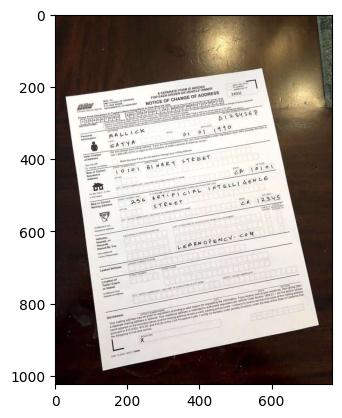

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2


img = cv2.imread('/content/imgeZ.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)


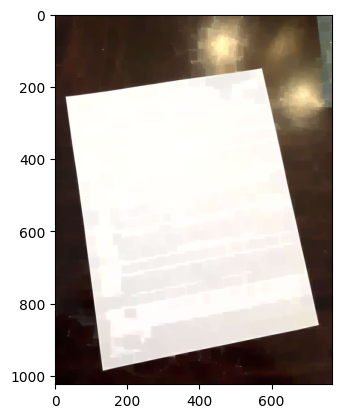

In [49]:
# remove text from the document

kernel  = np.ones((7,7), np.uint8)
img = cv2.morphologyEx(img_rgb, cv2.MORPH_CLOSE, kernel, iterations=3)
plt.imshow(img)

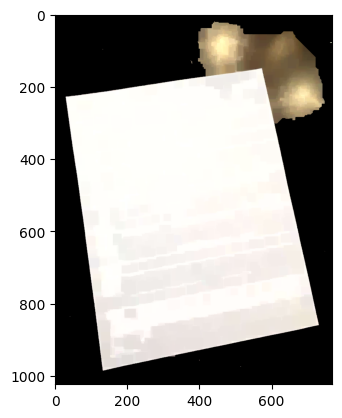

In [50]:
# rid of the background
"""
  take the corner 20 pixels as the background, and GrabCut
  automatically determines the foreground and background
"""
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64) #nền
fgdModel = np.zeros((1,65),np.float64)  #đối tượng
rect = (20,20,img.shape[1]-20,img.shape[0]-20) # hình chữ nhật để giữ lại
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)  # phân tách đối tượng
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

plt.imshow(img)



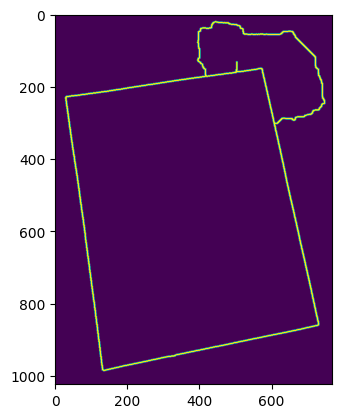

In [51]:
#using canny edege
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
# Edge Detection.
canny = cv2.Canny(gray, 0, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

plt.imshow(canny)

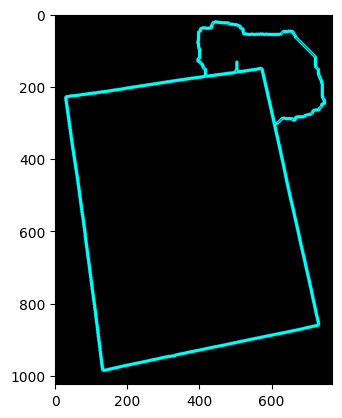

In [52]:
# contour detection
# Blank canvas.
con = np.zeros_like(img)
# Tìm đường viền cho các cạnh được phát hiện.
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Chỉ giữ lại đường viền lớn nhất được phát hiện.
page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)

plt.imshow(con)

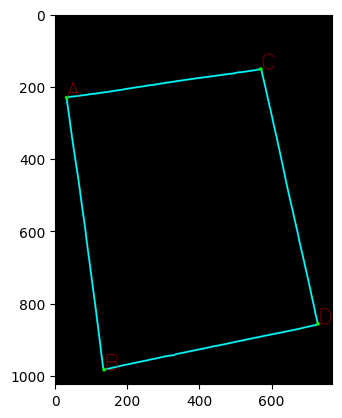

In [53]:
# detecting the corner points
# Blank canvas.
con = np.zeros_like(img)
# Lặp lại các đường viền.
for c in page:
  # Approximate the contour.
  epsilon = 0.02 * cv2.arcLength(c, True)
  corners = cv2.approxPolyDP(c, epsilon, True)
  # Nếu đường viền gần đúng của chúng ta có bốn điểm
  if len(corners) == 4:
      break
cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# Sắp xếp các góc và chuyển đổi chúng thành hình dạng mong muốn.
corners = sorted(np.concatenate(corners).tolist())

# Displaying the corners.
for index, c in enumerate(corners):
  character = chr(65 + index)
  cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 1, cv2.LINE_AA)

plt.imshow(con)


In [54]:

# Rearranging the detected corners (Sắp xếp lại các góc)
# sử dụng 1 hàm để sắp xếp lại tọa độ của 4 góc
def order_points(pts):
  """
  Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left
  """
  rect = np.zeros((4, 2), dtype='float32')
  pts = np.array(pts)
  s = pts.sum(axis=1)  # tổng của các tọa độ x và y của mỗi điểm
  # Top-left point will have the smallest sum.
  rect[0] = pts[np.argmin(s)]
  # Bottom-right point will have the largest sum.
  rect[2] = pts[np.argmax(s)]

  diff = np.diff(pts, axis=1)  # chênh lệch giữa các tọa độ x và y
  # Top-right point will have the smallest difference.
  rect[1] = pts[np.argmin(diff)]
  # Bottom-left will have the largest difference.
  rect[3] = pts[np.argmax(diff)]
  # Return the ordered coordinates.
  return rect.astype('int').tolist()



In [55]:
# finding the destination coordinantes
def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    return order_points(destination_corners)



In [56]:
# function to scan the documents:
def scan(img):
    # Resize image to workable size
    dim_limit = 1080
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)
    # Create a copy of resized original image for later use
    orig_img = img.copy()
    # Repeated Closing operation to remove text from the document.
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    # GrabCut
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img = img * mask2[:, :, np.newaxis]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    # Edge Detection.
    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # Finding contours for the detected edges.
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    # Detecting Edges through Contour approximation.
    # Loop over the contours.
    if len(page) == 0:
        return orig_img
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points.
        if len(corners) == 4:
            break
    # Sorting the corners and converting them to desired shape.
    corners = sorted(np.concatenate(corners).tolist())
    # For 4 corner points being detected.
    corners = order_points(corners)

    destination_corners = find_dest(corners)

    h, w = orig_img.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    # Perspective transform using homography.
    final = cv2.warpPerspective(orig_img, M, (destination_corners[2][0], destination_corners[2][1]),
                                flags=cv2.INTER_LINEAR)
    return final

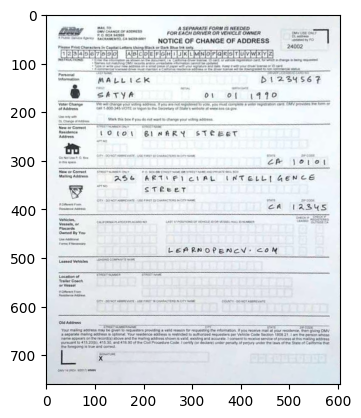

In [57]:
# Example usage
img = cv2.imread("/content/imgeZ.jpg")
scanned_image = scan(img)

plt.imshow(scanned_image)

BÀI 2

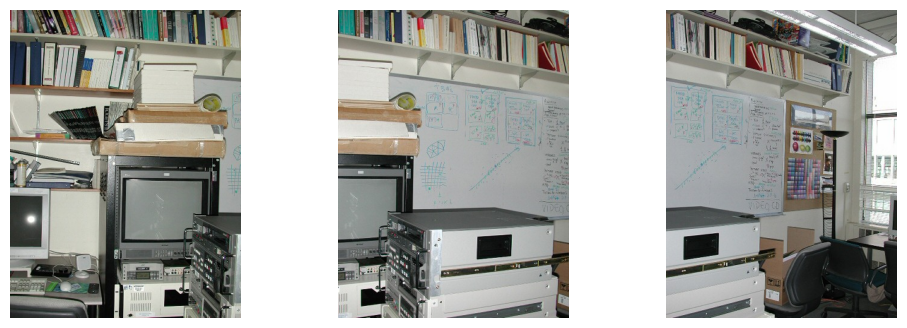

In [58]:
import cv2
import matplotlib.pyplot as plt

# Đường dẫn đến 3 tệp ảnh
image_paths = ["/content/grail02.jpg", "/content/grail01.jpg", "/content/grail00.jpg"]

# Đọc và lưu trữ 3 ảnh trong danh sách images
images = []
for path in image_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

# Hiển thị 3 ảnh
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axes[i].imshow(images[i])
    axes[i].axis('off')
plt.show()

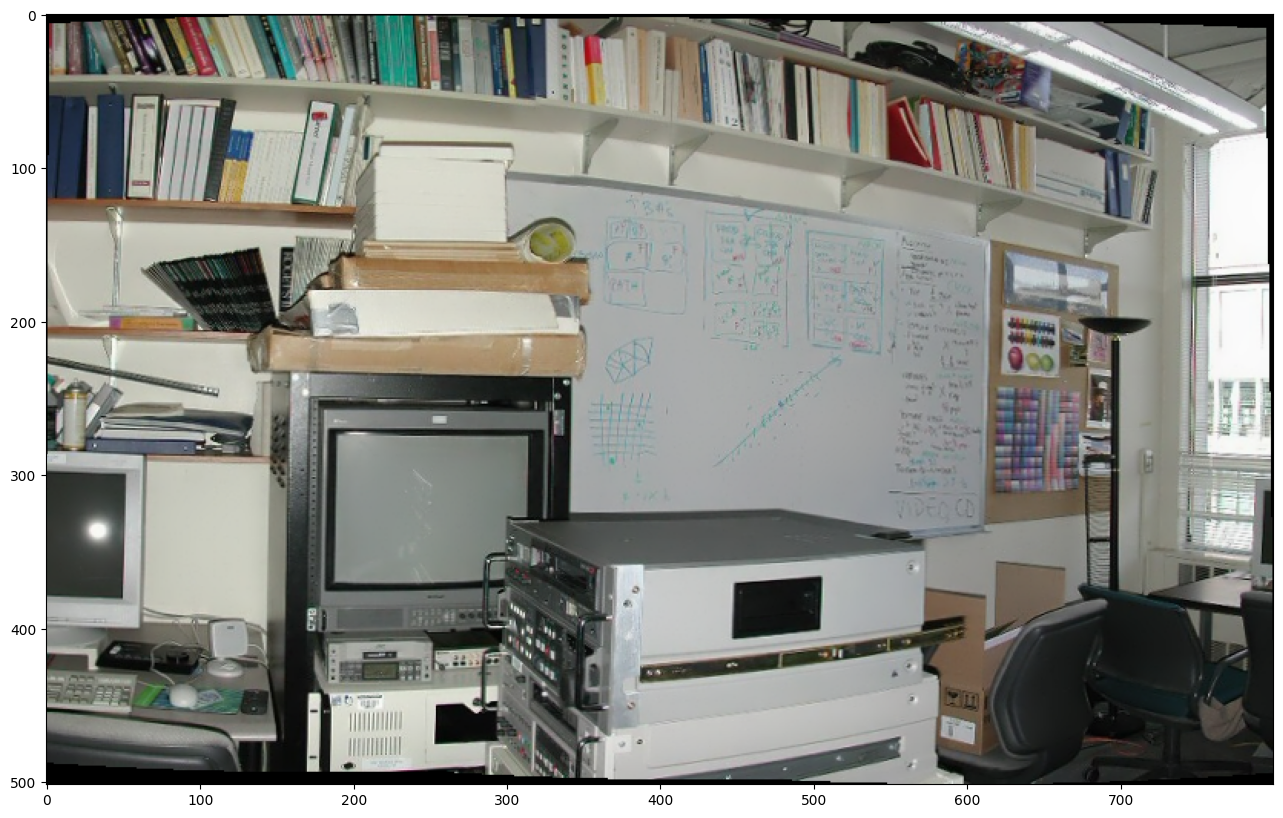

In [59]:
# stitch images
stitcher = cv2.Stitcher_create()
status, result = stitcher.stitch(images)
if status == 0:
  plt.figure(figsize=[30,10])
  plt.imshow((result))